In this part I would like to go through the process for modelling. The best hyperparameters for different models have been worked out in another notebook.

In [97]:
import pandas as pd
from collections import Counter
import re
import numpy as np
from sklearn.utils import shuffle

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Ploting
import seaborn as sns

In [98]:
df = pd.read_csv('./news_dataset.csv',index_col='Unnamed: 0')

In [99]:
df.head()

,title,content,publication,label
0,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,100percentfedup,fake
1,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,100percentfedup,fake
2,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,100percentfedup,fake
3,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,100percentfedup,fake
4,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,100percentfedup,fake


In [100]:
df=df.dropna()

In [101]:
df['fakeness']=df['label'].apply(lambda x:1 if x=='fake' else 0)

In [102]:
df[df['label']=='fake'].shape

(12273, 5)

In [103]:
df[df['label']=='real'].shape

(15712, 5)

In [104]:
# Preparing the target and predictors for modeling

X_content_text = df.content.values
X_title_text = df.title.values
y = df.fakeness.values

In [105]:
X_content_text_train, X_content_text_test, y_content_text_train, y_content_text_test = train_test_split(X_content_text,y, test_size = 0.2, random_state=1234,stratify=y)

In [106]:
# Baseline score
df['label'].value_counts(normalize=True)

real    0.561444
fake    0.438556
Name: label, dtype: float64

In [107]:
class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''
    
    def __init__(self, model, X_data, Y_data, X_test=None, Y_test=None, 
                 n_splits=3, init_chunk_size = 1000000, chunk_spacings = 100000, average = "binary"):

        self.X, self.Y =  shuffle(X_data, Y_data, random_state=1234)
        
        
        self.model = model
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings        
        
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.X_holdout = []
        self.Y_holdout = []
        
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []
        
        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []
        
        self.training_size = []
        self.averageType = average
    
    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''
        
        # get total number of points
        self.N_total = self.X.shape[0]
        # partition data into chunks for learning
        self.chunks = list(np.arange(self.chunk_size, self.N_total, self.chunk_spacings ))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append( self.chunks[-1] + self.remainder )



    def train_for_learning_curve(self):
        '''KFold cross validates model and records metric scores for learning curves. 
           Metrics scored are f1-score, precision, recall, and accuracy'''

        # partiton data into chunks 
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set 
        self.skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n_points in self.chunks: 
            
        
            # split the first n samples in k folds 
            for train_index, test_index in self.skf.split(self.X[:n_points], self.Y[:n_points]):
                self.train_index, self.test_index = train_index, test_index                
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]
                
                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()   
                
            self.log_metric_score_means_()
            self.training_size.append(n_points)
        
    def validate_for_holdout_set(self, X_holdout, Y_holdout):
        
        
        self.X_test = X_holdout
        self.Y_test = Y_holdout
        
        # partiton data into chunks 
        self.make_chunks()
        
        for n_points in self.chunks:
            
            self.X_train = self.X[:n_points]
            self.Y_train = self.Y[:n_points]

            self.model.fit(self.X_train, self.Y_train)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
            self.log_metric_scores_()   

            self.log_metric_score_means_()
            self.training_size.append(n_points)
            
            
    
                            
    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))
        
        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))
        
        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))
        
        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))
        
        self.reinitialize_metric_lists_()
            
            
    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

            
    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score( self.Y_train, self.y_pred_train) )

        self.pre_train.append(precision_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score( self.Y_train, self.y_pred_train, average=self.averageType) )

        self.f1_test.append(f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(self.Y_test, self.y_pred_test,average=self.averageType))
            

    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''
        
        fig = plt.figure(figsize = (17,12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(222)   # right 
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4);
        
        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(224)   # right 
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4);

In [108]:
# Stemming and Lemmatizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

from nltk.tokenize import RegexpTokenizer

Regexp = RegexpTokenizer(r'\w+')

tokenizer= Regexp.tokenize# Stemming and Lemmatizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

from nltk.tokenize import RegexpTokenizer

Regexp = RegexpTokenizer(r'\w+')

tokenizer= Regexp.tokenize

# Model 1: CountVectorizer & Logistic Regression

In [38]:
cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,1),tokenizer=LemmaTokenizer(),decode_error='ignore')
lr_content = LogisticRegression(penalty='l1')


In [41]:
cvec.fit(X_content_text_train)


Xcvec_train = cvec.transform(X_content_text_train)
Xcvec_test = cvec.transform(X_content_text_test)

# Fit the classifier
lr_content.fit(Xcvec_train,y_content_text_train)

# Create the predictions for Y training data
lr_preds = lr_content.predict(Xcvec_test)

print(lr_content.score(Xcvec_test, y_content_text_test))

0.9733785956762552


E:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Model 2: CountVectorizer & MultinomialNB

In [43]:
cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,1),tokenizer=LemmaTokenizer(),decode_error='ignore')
nb_content = MultinomialNB(alpha =0.36)


In [44]:
cvec.fit(X_content_text_train)


Xcvec_train = cvec.transform(X_content_text_train)
Xcvec_test = cvec.transform(X_content_text_test)

# Fit the classifier
nb_content.fit(Xcvec_train,y_content_text_train)

# Create the predictions for Y training data
nb_preds = nb_content.predict(Xcvec_test)

print(nb_content.score(Xcvec_test, y_content_text_test))

E:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.9385385027693407


# Model 3: CountVectorizer & Random Forest

In [45]:
cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,2),tokenizer=LemmaTokenizer(),decode_error='ignore')
rcf_content = RandomForestClassifier(n_estimators=100,n_jobs=3)


In [46]:
cvec.fit(X_content_text_train)


Xcvec_train = cvec.transform(X_content_text_train)
Xcvec_test = cvec.transform(X_content_text_test)

# Fit the classifier
rcf_content.fit(Xcvec_train,y_content_text_train)

# Create the predictions for Y training data
rcf_preds = rcf_content.predict(Xcvec_test)

print(rcf_content.score(Xcvec_test, y_content_text_test))

E:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


0.897445059853493


# Model 4: TF-IDF & Logistic Regression

In [47]:
tfidf =TfidfVectorizerfidfVectorizer(max_df=0.75, min_df= 3,ngram_range= (1, 3))
lr_content = LogisticRegression(penalty='l1')


In [48]:
tfidf.fit(X_content_text_train)


tfidf_train = tfidf.transform(X_content_text_train)
tfidf_test = tfidf.transform(X_content_text_test)

# Fit the classifier
lr_content.fit(tfidf_train,y_content_text_train)

# Create the predictions for Y training data
lr_preds = lr_content.predict(tfidf_test)

print(lr_content.score(tfidf_test, y_content_text_test))

E:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9203144541718777


# Model 5: TF-IDF & MultinomialNB

In [49]:
tfidf = TfidfVectorizer(max_df=0.75, min_df= 3,ngram_range= (1, 3))
nb_content = MultinomialNB(alpha =0.36)


In [50]:
tfidf.fit(X_content_text_train)


tfidf_train = tfidf.transform(X_content_text_train)
tfidf_test = tfidf.transform(X_content_text_test)

# Fit the classifier
nb_content.fit(tfidf_train,y_content_text_train)

# Create the predictions for Y training data
nb_preds = nb_content.predict(tfidf_test)

print(nb_content.score(tfidf_test, y_content_text_test))

0.7646953725209934


# Model 6： TF-IDF & Random Forest

In [51]:
tfidf = TfidfVectorizer(max_df=0.75, min_df= 3,ngram_range= (1, 3))
rcf_content = RandomForestClassifier(n_estimators=100,n_jobs=3)


In [52]:
tfidf.fit(X_content_text_train)


tfidf_train = tfidf.transform(X_content_text_train)
tfidf_test = tfidf.transform(X_content_text_test)

# Fit the classifier
rcf_content.fit(tfidf_train,y_content_text_train)

# Create the predictions for Y training data
rcf_preds = rcf_content.predict(tfidf_test)

print(rcf_content.score(tfidf_test, y_content_text_test))

0.8495622654993746


In [123]:
# Create lists for customize stop_words
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)

common_unigrams = ['non','anti','pre','self','mid','thirds','th','multi','dcg','tags','dec']
common_bigrams = ['year old','s view','map make','pic twitter','caption content','https t']

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

# Best Explanation -CountVectorizer & Logistic Regression¶

In [124]:
cvec = CountVectorizer(stop_words = custom,ngram_range=(1,2),tokenizer=Regexp.tokenize,decode_error='ignore')
lr_content = LogisticRegression(penalty='l1')

cvec.fit(X_content_text_train)


Xcvec_train = cvec.transform(X_content_text_train)
Xcvec_test = cvec.transform(X_content_text_test)

# Fit the classifier
lr_content.fit(Xcvec_train,y_content_text_train)

# Create the predictions for Y training data
lr_preds = lr_content.predict(Xcvec_test)

print(lr_content.score(Xcvec_test, y_content_text_test))

E:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9308558156155083


In [125]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_content_text_test, lr_preds)
cnf_matrix

array([[2929,  213],
       [ 174, 2281]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

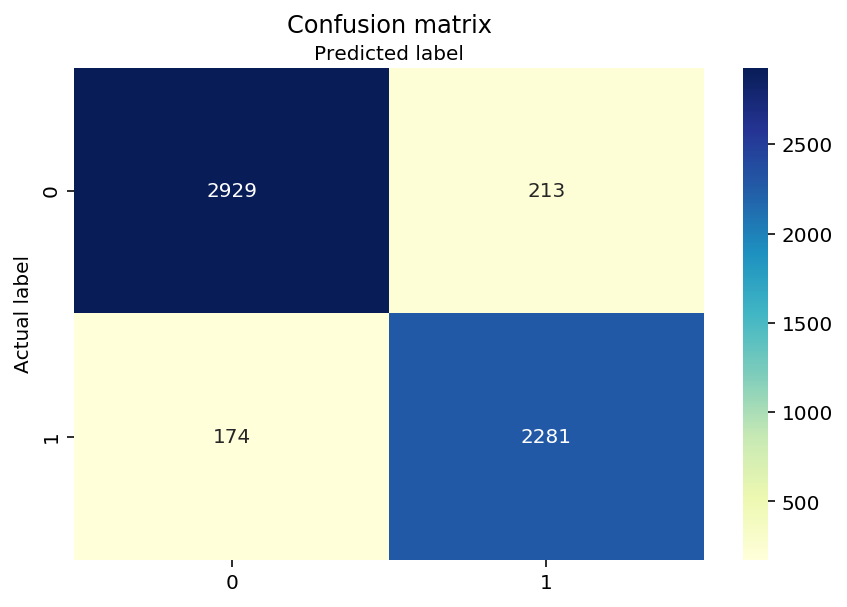

In [126]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [127]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

In [128]:
# Print Scores 

print("Accuracy:",round(metrics.accuracy_score(y_content_text_test, lr_preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_content_text_test, lr_preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_content_text_test, lr_preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 93.09 %
Precision: 91.46 %
Recall: 92.91 %
Specificity: 93.22 %
Misclassification Rate: 6.2 %


In [129]:
X_content_cvec = cvec.fit_transform(X_content_text)

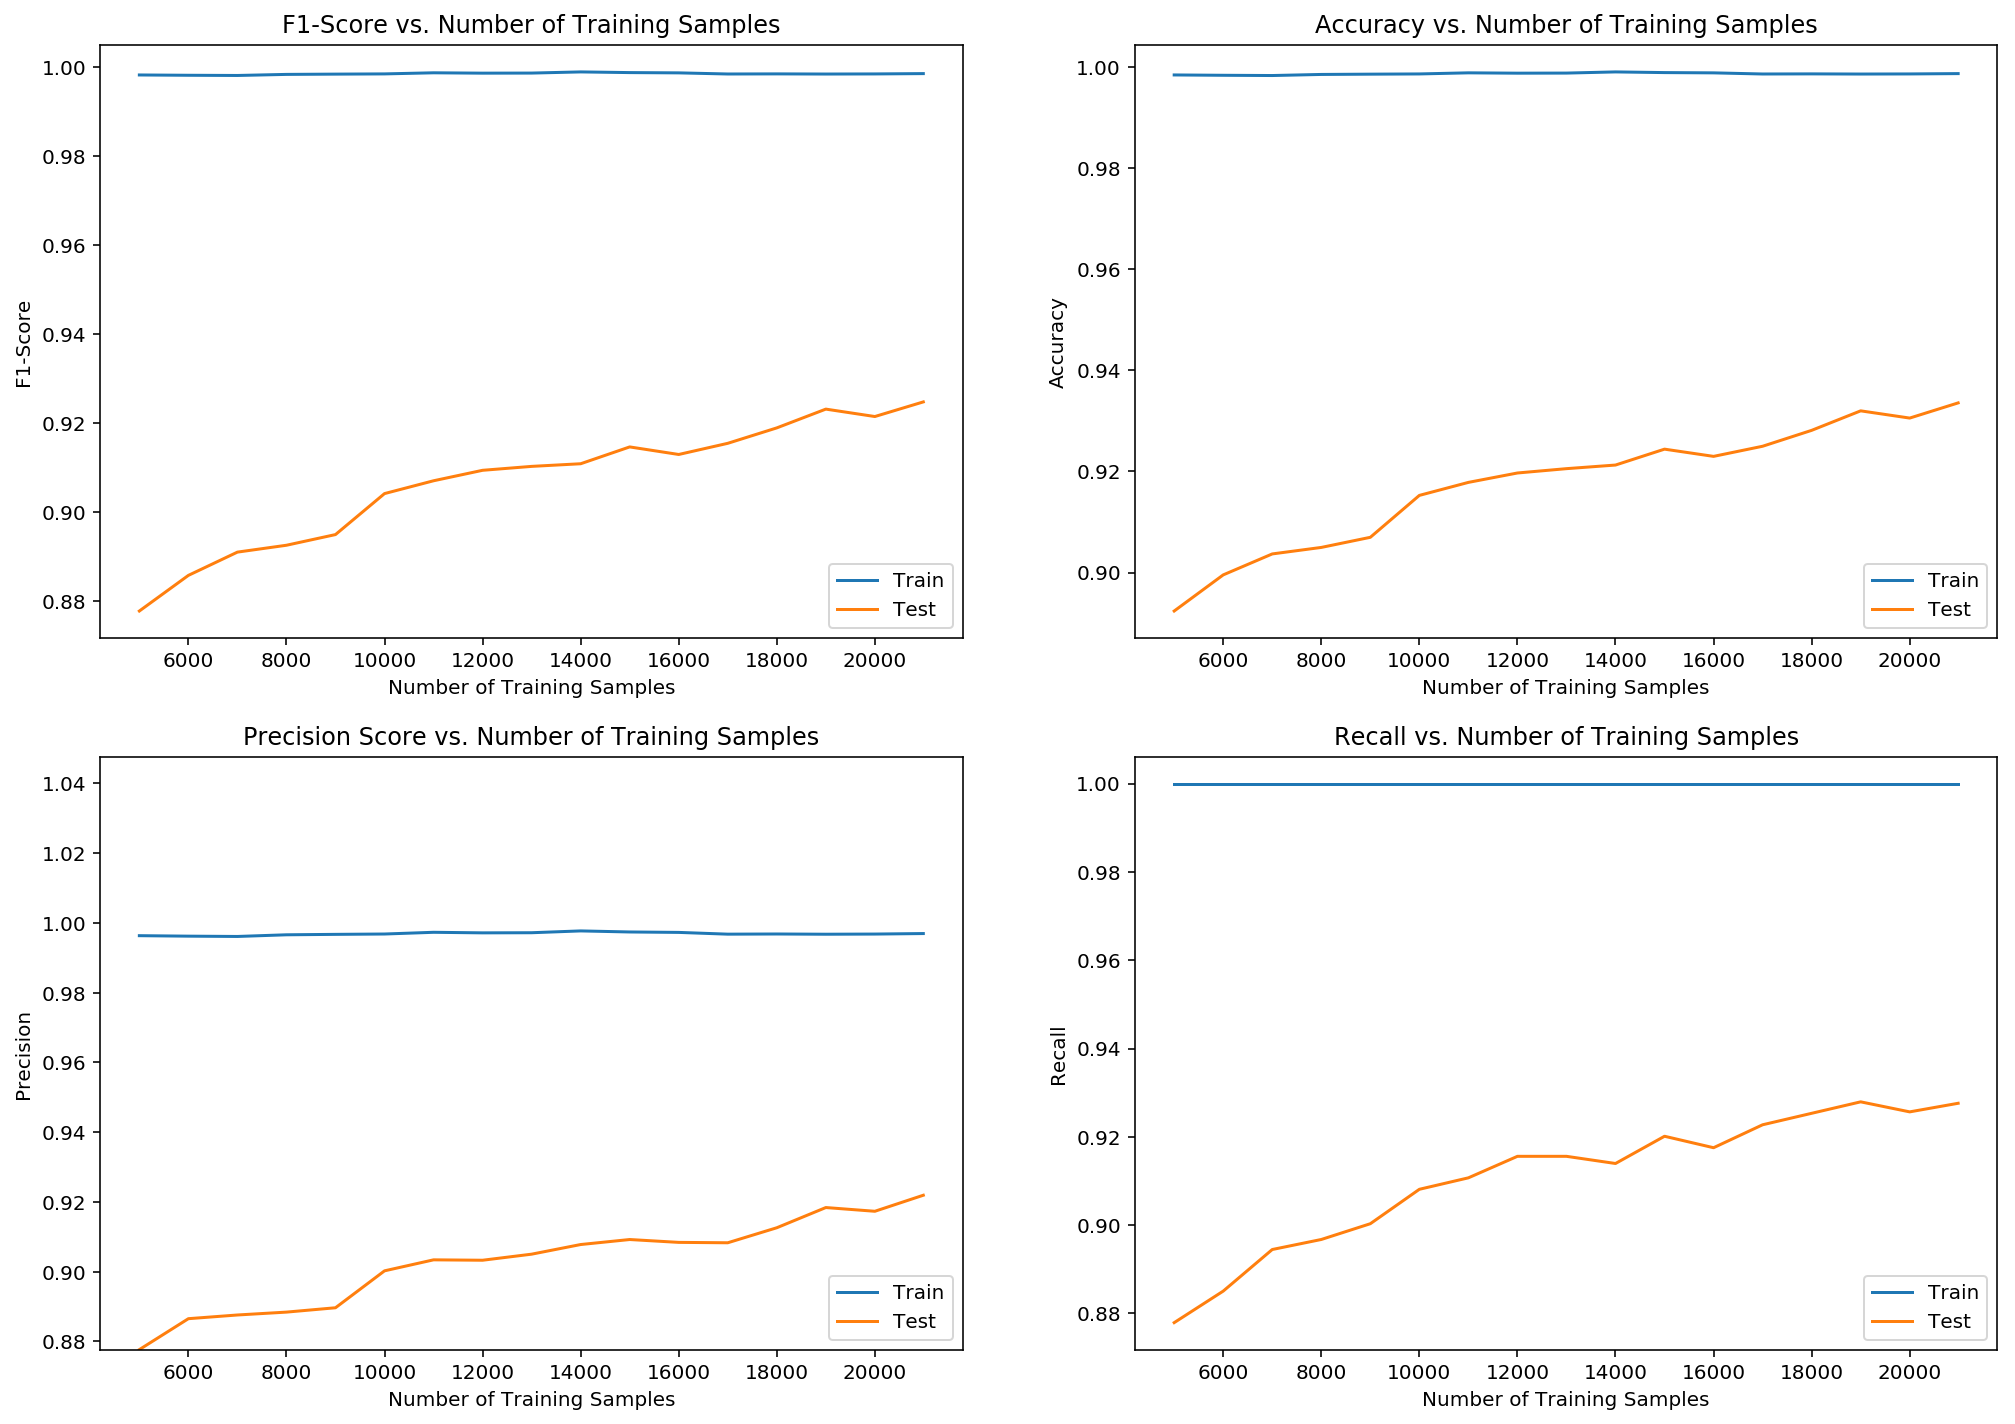

In [130]:
xtrain,xtest,ytrain,ytest = train_test_split(X_content_cvec,y)

cv = cross_validation(lr_content, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

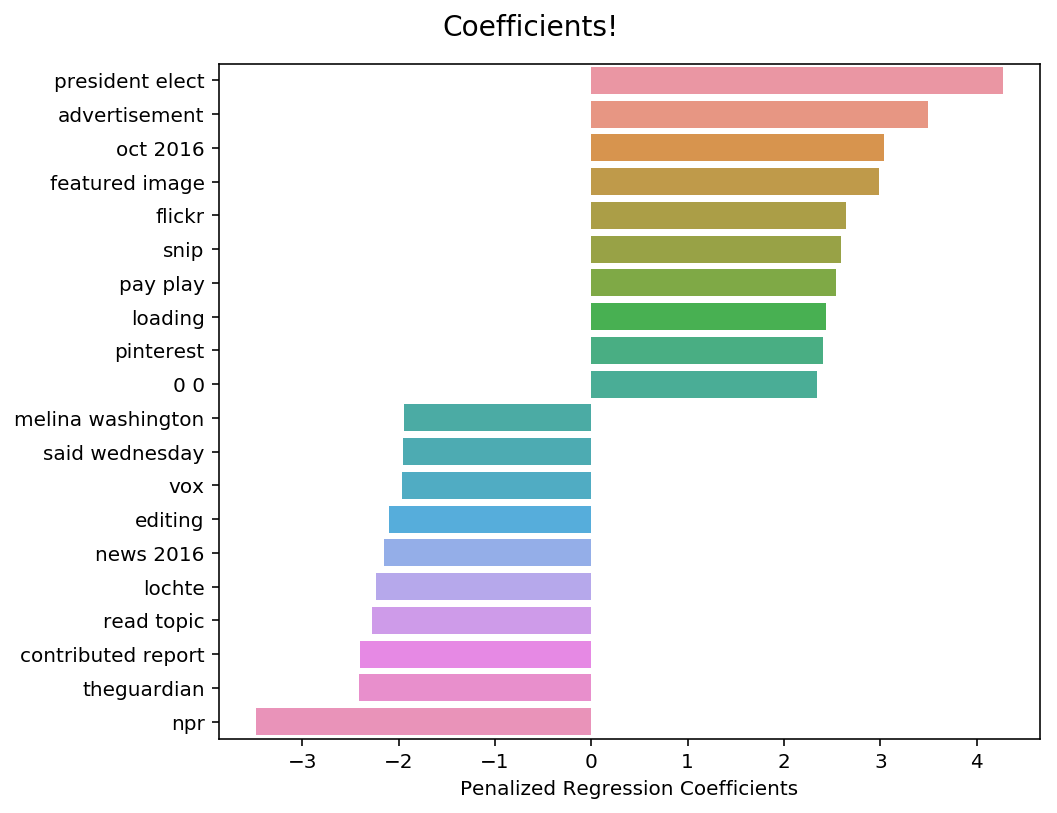

In [131]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr_content.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients!', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [132]:
print("The word that contributes the most positively to being from Fake News is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("-----------------------------------")

The word that contributes the most positively to being from Fake News is president elect followed by advertisement and oct 2016 .
-----------------------------------


In [134]:
# Show coefficients that affect whether a news is fake or not
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

,penalized_regression_coefficients,exp
president elect,4.267,71.307392
advertisement,3.491,32.818750
oct 2016,3.035,20.800978
featured image,2.988,19.845951
flickr,2.642,14.041258
snip,2.588,13.303139
pay play,2.541,12.692357
loading,2.437,11.438673
pinterest,2.399,11.012159
0 0,2.346,10.443711


In [ ]:
'0 0',